In [16]:
import csv
import operator
import pandas as pd
from collections import OrderedDict
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import time
import datetime
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
from xgboost.sklearn import XGBClassifier
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import accuracy_score, mean_absolute_error, r2_score
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
#from fancyimpute import NuclearNormMinimization
from keras.wrappers.scikit_learn import KerasRegressor

In [17]:
# Get All Data Sets
macro = {}
with open('/path', 'r') as f1:
    reader = csv.reader(f1, delimiter=',', quotechar='"', skipinitialspace=True)
    header = next(reader)
    for name in header:
        macro[name] = []
    for row in reader:
        for i, value in enumerate(row):
            macro[header[i]].append(value)
    f1.close()
macro = pd.DataFrame.from_dict(macro)
macro = macro.replace(['NA'], np.nan)
macro['timestamp'] = pd.to_datetime(macro['timestamp'])
test = {}
with open('/path', 'r') as f1:
    reader = csv.reader(f1, delimiter=',', quotechar='"', skipinitialspace=True)
    header = next(reader)
    for name in header:
        test[name] = []
    for row in reader:
        for i, value in enumerate(row):
            test[header[i]].append(value)
    f1.close()
test = pd.DataFrame.from_dict(test)
test = test.replace({' ': '', '#!': 'NA'}, regex=True)
test = test.replace({'#!': 'NA'}, regex=True)
test = test.replace(['NA'], np.nan)
test = test.replace(['#!'], np.nan, regex=True)
test['timestamp'] = pd.to_datetime(test['timestamp'])
train = {}
with open('/path', 'r') as f1:
    reader = csv.reader(f1, delimiter=',', quotechar='"', skipinitialspace=True)
    header = next(reader)
    for name in header:
        train[name] = []
    for row in reader:
        for i, value in enumerate(row):
            train[header[i]].append(value)
    f1.close()
train = pd.DataFrame.from_dict(train)
train = train.replace({' ': '', '#!': 'NA'}, regex=True)
train = train.replace({'#!': 'NA'}, regex=True)
train = train.replace(['NA'], np.nan)
train = train.replace(['#!'], np.nan, regex=True)
train['timestamp'] = pd.to_datetime(train['timestamp'])
train = pd.merge(train, macro, on='timestamp', how='left')
test = pd.merge(test, macro, on='timestamp', how='left')
train['timestamp'] = (train['timestamp'] - datetime.datetime(1970,1,1))
test['timestamp'] = (test['timestamp'] - datetime.datetime(1970,1,1))
train['timestamp'] = (train['timestamp'] / np.timedelta64(1, 'D')).astype(int)
test['timestamp'] = (test['timestamp'] / np.timedelta64(1, 'D')).astype(int)

In [18]:
nonnumeric_columns = ['product_type', 
                      'sub_area', 
                      'culture_objects_top_25', 
                      'thermal_power_plant_raion', 
                      'incineration_raion',
                      'oil_chemistry_raion',
                      'radiation_raion',
                      'railroad_terminal_raion',
                      'big_market_raion',
                      'nuclear_reactor_raion',
                      'detention_facility_raion',
                      'water_1line', 
                      'big_road1_1line',
                      'railroad_1line',
                      'ecology',
                      'child_on_acc_pre_school']
le = LabelEncoder()
for feature in nonnumeric_columns:
    train[feature] = le.fit_transform(train[feature].astype(str))
for feature in nonnumeric_columns:
    test[feature] = le.fit_transform(test[feature].astype(str))

In [19]:
train = train.replace({'\$': '', ',': '', '  ': '', ' ': ''}, regex=True)
train = train.replace(r'\s+', np.nan, regex=True)
train = train.astype(np.float)
test = test.replace({'\$': '', ',': '', '  ': '', ' ': ''}, regex=True)
test = test.replace(r'\s+', np.nan, regex=True)
test = test.astype(np.float)

target = 'price_doc'
IDcol = 'id'

In [20]:
def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='rmse', early_stopping_rounds=early_stopping_rounds, verbose_eval=True) 
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    
    #Print model report:
    print ("\nModel Report")
    print ("Mean Absolute Error : %.4g" % metrics.r2_score(dtrain[target].values, dtrain_predictions)) 
                        
    feat_imp = pd.DataFrame(data = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False), columns=['Importance'])
    feat_imp = feat_imp[feat_imp['Importance'] > feat_imp['Importance'].quantile(.95)] #Use this line only the first time running the code
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    return(feat_imp)
    return(cvresult)

[0]	train-rmse:7.83634e+06+33910.1	test-rmse:7.83852e+06+135261
[1]	train-rmse:7.17307e+06+31248.3	test-rmse:7.18511e+06+143311
[2]	train-rmse:6.58705e+06+23495.2	test-rmse:6.61516e+06+154413
[3]	train-rmse:6.07512e+06+33099.5	test-rmse:6.11687e+06+148511
[4]	train-rmse:5.614e+06+37147.9	test-rmse:5.66689e+06+148447
[5]	train-rmse:5.2117e+06+40420.5	test-rmse:5.27795e+06+150059
[6]	train-rmse:4.85387e+06+45405.4	test-rmse:4.9377e+06+145897
[7]	train-rmse:4.53068e+06+43572.3	test-rmse:4.62726e+06+148779
[8]	train-rmse:4.25162e+06+41029	test-rmse:4.36553e+06+156217
[9]	train-rmse:4.00377e+06+38270.3	test-rmse:4.13481e+06+159978
[10]	train-rmse:3.78894e+06+38406.9	test-rmse:3.9355e+06+163014
[11]	train-rmse:3.59964e+06+36060.1	test-rmse:3.76574e+06+168343
[12]	train-rmse:3.43316e+06+35553.5	test-rmse:3.61501e+06+172697
[13]	train-rmse:3.29215e+06+35699.7	test-rmse:3.49172e+06+172745
[14]	train-rmse:3.16535e+06+36229.9	test-rmse:3.38279e+06+172744
[15]	train-rmse:3.05691e+06+34402.2	test-r

[127]	train-rmse:1.91195e+06+5264.81	test-rmse:2.62451e+06+157948
[128]	train-rmse:1.90936e+06+5798.31	test-rmse:2.6238e+06+158208
[129]	train-rmse:1.90707e+06+5028.83	test-rmse:2.62301e+06+158234
[130]	train-rmse:1.90384e+06+4322.42	test-rmse:2.62209e+06+158605
[131]	train-rmse:1.90183e+06+4681.01	test-rmse:2.62177e+06+158278
[132]	train-rmse:1.89942e+06+4912.36	test-rmse:2.62123e+06+157690
[133]	train-rmse:1.89767e+06+4534.14	test-rmse:2.62091e+06+157984
[134]	train-rmse:1.89562e+06+4967.52	test-rmse:2.62075e+06+157906
[135]	train-rmse:1.89394e+06+5134.94	test-rmse:2.6207e+06+157841
[136]	train-rmse:1.89053e+06+5276.09	test-rmse:2.62018e+06+156827
[137]	train-rmse:1.88816e+06+4826.98	test-rmse:2.62063e+06+156737
[138]	train-rmse:1.88585e+06+5014.25	test-rmse:2.62062e+06+156689
[139]	train-rmse:1.88296e+06+4511.7	test-rmse:2.62047e+06+156640
[140]	train-rmse:1.88038e+06+4944.63	test-rmse:2.62078e+06+155849
[141]	train-rmse:1.87701e+06+4913.72	test-rmse:2.62072e+06+155183
[142]	train-r

[252]	train-rmse:1.66425e+06+5190.56	test-rmse:2.60879e+06+154940
[253]	train-rmse:1.66288e+06+4994.48	test-rmse:2.60884e+06+154765
[254]	train-rmse:1.66126e+06+4893.82	test-rmse:2.60879e+06+154691
[255]	train-rmse:1.65928e+06+5324.69	test-rmse:2.60877e+06+154622
[256]	train-rmse:1.65737e+06+5856.85	test-rmse:2.60823e+06+154843
[257]	train-rmse:1.65546e+06+5745.1	test-rmse:2.60822e+06+154721
[258]	train-rmse:1.65437e+06+5320.26	test-rmse:2.60826e+06+154870
[259]	train-rmse:1.65256e+06+4968.25	test-rmse:2.60793e+06+155142
[260]	train-rmse:1.65125e+06+4941.53	test-rmse:2.6078e+06+155299
[261]	train-rmse:1.64992e+06+4982.37	test-rmse:2.60802e+06+155273
[262]	train-rmse:1.64858e+06+4955.1	test-rmse:2.60772e+06+155387
[263]	train-rmse:1.64704e+06+4911.53	test-rmse:2.60775e+06+155615
[264]	train-rmse:1.64561e+06+4871.22	test-rmse:2.60754e+06+155601
[265]	train-rmse:1.64416e+06+4820.36	test-rmse:2.60791e+06+155832
[266]	train-rmse:1.6427e+06+4975.96	test-rmse:2.60758e+06+155999
[267]	train-rm

[377]	train-rmse:1.48534e+06+6072.43	test-rmse:2.60718e+06+155734
[378]	train-rmse:1.48448e+06+6024.04	test-rmse:2.60723e+06+155840
[379]	train-rmse:1.48322e+06+6337.86	test-rmse:2.60738e+06+155779
[380]	train-rmse:1.48158e+06+6135.94	test-rmse:2.60726e+06+155863
[381]	train-rmse:1.47999e+06+5570.62	test-rmse:2.60705e+06+156057
[382]	train-rmse:1.47877e+06+5469.38	test-rmse:2.60739e+06+155961
[383]	train-rmse:1.47738e+06+5583.02	test-rmse:2.60735e+06+156048
[384]	train-rmse:1.47631e+06+5434.85	test-rmse:2.60747e+06+155934
[385]	train-rmse:1.47491e+06+5568.11	test-rmse:2.60732e+06+155782
[386]	train-rmse:1.47347e+06+5623.13	test-rmse:2.60749e+06+155680
[387]	train-rmse:1.47232e+06+6002.97	test-rmse:2.60744e+06+156024
[388]	train-rmse:1.47064e+06+5799.13	test-rmse:2.6075e+06+155825
[389]	train-rmse:1.4696e+06+5723.78	test-rmse:2.60745e+06+156904
[390]	train-rmse:1.46855e+06+5781.9	test-rmse:2.60742e+06+156800
[391]	train-rmse:1.46759e+06+5594.14	test-rmse:2.60762e+06+157011
[392]	train-r

,Importance
full_sq,640
life_sq,254
build_year,240
0_13_all,224
floor,220
additional_education_km,134
kitch_sq,99
basketball_km,96
timestamp,94
num_room,94


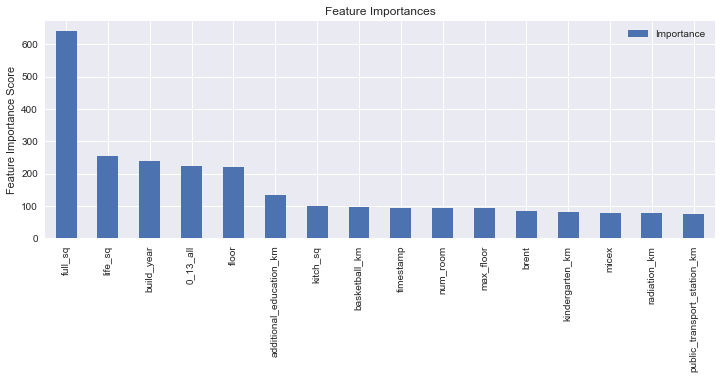

In [21]:
#Choose all predictors except target & IDcols
predictors = [x for x in train.columns if x not in [target, IDcol]]
xgb1 = XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:linear',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, train, predictors)

In [22]:
#Selected from the top 95th percentile of feature importance.
train1 = train[['id', 'full_sq', 'life_sq', 'build_year', '0_13_all', 'floor', 'additional_education_km', 
              'kitch_sq', 'basketball_km', 'timestamp', 'num_room', 'max_floor', 'brent', 
              'kindergarten_km', 'micex', 'radiation_km', 'public_transport_station_km', 'price_doc']] 
test1 = test[['id', 'full_sq', 'life_sq', 'build_year', '0_13_all', 'floor', 'additional_education_km', 
              'kitch_sq', 'basketball_km', 'timestamp', 'num_room', 'max_floor', 'brent', 
              'kindergarten_km', 'micex', 'radiation_km', 'public_transport_station_km']] 
predictors = [x for x in train1.columns if x not in [target, IDcol]]

In [23]:
train1.isnull().sum()

id                                 0
full_sq                            0
life_sq                         6383
build_year                     13605
0_13_all                           0
floor                            167
additional_education_km            0
kitch_sq                        9572
basketball_km                      0
timestamp                          0
num_room                        9572
max_floor                       9572
brent                              0
kindergarten_km                    0
micex                              0
radiation_km                       0
public_transport_station_km        0
price_doc                          0
dtype: int64

In [24]:
#Imput data
from sklearn.base import TransformerMixin
class DataFrameImputer(TransformerMixin):
    def fit(self, X, y=None):
        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].median() for c in X],
            index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.fill)

In [25]:
#Notes on this, It's unclear if the best imputation has been done. Should research ways to optimize imputes.
train_test = train1.append(test1)
train_test_imputed = DataFrameImputer().fit_transform(train_test)
train_imputed = train_test_imputed[0:train.shape[0]]
test_imputed = train_test_imputed[train.shape[0]::]
train_imputed = train_imputed[['id', 'full_sq', 'life_sq', 'build_year', '0_13_all', 'floor', 'additional_education_km', 
              'kitch_sq', 'basketball_km', 'timestamp', 'num_room', 'max_floor', 'brent', 
              'kindergarten_km', 'micex', 'radiation_km', 'public_transport_station_km']] 

In [26]:
#mpute Data using nuclearNormMinimization
#train1_imputed = NuclearNormMinimization(verbose=True).complete(train1)

In [27]:
sns.pairplot(train1_imputed, 
             # kind="reg", 
             diag_kind="kde") # , 
             #plot_kws=dict(s=50, edgecolor="b", linewidth=1))#, 
             #diag_kws=dict(shade=True))

NameError: name 'train1_imputed' is not defined

In [ ]:
train1_corr = train1_imputed.fillna(value=0).corr(method='pearson')
mask = np.zeros_like(train1_corr)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(train1_corr, cmap="YlGnBu", vmax=1, vmin=-1, mask = mask, linewidths=2.5)
plt.yticks(rotation=0) 
plt.xticks(rotation=90)
ax.collections[0].colorbar.set_ticks([-1, 1])
plt.show()

In [ ]:
# Using XGBoost
gbm = xgb.XGBRegressor(learning_rate = 0.1,
         n_estimators=401,
         max_depth=5,
         min_child_weight=1,
         gamma=0,
         subsample=0.8,
         colsample_bytree=0.8,
         objective= 'reg:linear',
         nthread=4,
         scale_pos_weight=1,
         seed=27).fit(train1_imputed[predictors],train1_imputed[target]) 

preds = gbm.predict(train1_imputed[predictors]) 
accuracy = metrics.r2_score(np.asarray(train1_imputed[target], dtype='float32'), preds)
print("R2 Score: : %.4g" % (accuracy))

In [ ]:
#Using Neural Network
def nn_model():
    model = Sequential()
    model.add(Dense(94, input_dim=47, kernel_initializer='normal', activation='relu'))
    model.add(Dense(94, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(47, kernel_initializer='normal', activation='relu'))
    model.add(Dense(47, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, kernel_initializer='normal'))
    
    model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])
    return model

In [ ]:
nn_model = nn_model()

nn_history = nn_model.fit(train1_imputed[predictors],train1_imputed[target],
                            nb_epoch=10, batch_size=16, verbose=0)

In [ ]:
# An effort to do parameter tuning, but my computer isn't powerful enough.
param_test1 = {
 'max_depth':list(range(3,10,2)),
 'min_child_weight':list(range(1,6,2))
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=401, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'reg:linear', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='r2',n_jobs=4,iid=False, cv=5, verbose=20)
gsearch1.fit(train1[predictors],train1[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

C:\Users\lemkp0\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)


Fitting 3 folds for each of 12 candidates, totalling 36 fits


In [ ]:
# Optimize batch size and epochs for neural network. Need to access Amazon Web Services?
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(94, input_dim=47, kernel_initializer='normal', activation='relu'))
    model.add(Dense(94, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(47, kernel_initializer='normal', activation='relu'))
    model.add(Dense(47, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, kernel_initializer='normal'))
    
    model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])
    return model
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# load dataset
dataset = train1_imputed
# split into input (X) and output (Y) variables
X = dataset[['full_sq', 'life_sq', 'build_year', '0_13_all', 'floor', 'additional_education_km', 
              'kitch_sq', 'basketball_km', 'timestamp', 'num_room', 'max_floor', 'brent', 
              'kindergarten_km', 'micex', 'radiation_km', 'public_transport_station_km']] # predictors
Y = dataset['price_doc'] # target
# create model

model = KerasRegressor(build_fn=create_model, verbose=1)
# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, verbose=20)
grid_result = grid.fit(X, Y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# This is for selecting the best optimizer
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(12, input_dim=8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# load dataset
dataset = train1_imputed
# split into input (X) and output (Y) variables
X = dataset[['full_sq', 'life_sq', 'build_year', '0_13_all', 'floor', 'additional_education_km', 
              'kitch_sq', 'basketball_km', 'timestamp', 'num_room', 'max_floor', 'brent', 
              'kindergarten_km', 'micex', 'radiation_km', 'public_transport_station_km']] # predictors
Y = dataset['price_doc'] # target
# create model

model = KerasRegressor(build_fn=create_model, epochs=100, batch_size=10, verbose=1)
# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, verbose=20)
grid_result = grid.fit(X, Y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))